### Machine Learning for Codon Usage Classification

In [41]:
import pandas as pd
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt 

# Classification Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor

# Metric tools, and utility methods
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report,accuracy_score,recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV

### Preparing the Data

In [42]:
df = pd.read_csv('../raw_data/codon_usage.csv')

df['Kingdom'] = df['Kingdom'].astype('category')
df['Kingdom_Code'] = df['Kingdom'].cat.codes

codon_df = df.loc[:,df.columns[6:]]

# There is a string data on position 5063, so we need to drop it:
codon_df = codon_df.drop([5063])
codon_df = codon_df.apply(pd.to_numeric)
print(codon_df.head())

       UUC      UUA      UUG      CUU      CUC      CUA      CUG      AUU  \
0  0.01203  0.00050  0.00351  0.01203  0.03208  0.00100  0.04010  0.00551   
1  0.01357  0.00068  0.00678  0.00407  0.02849  0.00204  0.04410  0.01153   
2  0.02180  0.01357  0.01543  0.00782  0.01111  0.01028  0.01193  0.02283   
3  0.02245  0.01619  0.00992  0.01567  0.01358  0.00940  0.01723  0.02402   
4  0.01371  0.00767  0.03679  0.01380  0.00548  0.00473  0.02076  0.02716   

       AUC      AUA  ...      AGA      AGG      GAU      GAC      GAA  \
0  0.02005  0.00752  ...  0.01303  0.03559  0.01003  0.04612  0.01203   
1  0.02510  0.00882  ...  0.01696  0.03596  0.01221  0.04545  0.01560   
2  0.01604  0.01316  ...  0.01974  0.02489  0.03126  0.02036  0.02242   
3  0.02245  0.02507  ...  0.01410  0.01671  0.03760  0.01932  0.03029   
4  0.00867  0.01310  ...  0.01494  0.01734  0.04148  0.02483  0.03359   

       GAG      UAA      UAG      UGA  Kingdom_Code  
0  0.04361  0.00251  0.00050  0.00000       

/tmp/ipykernel_260436/964674226.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../raw_data/codon_usage.csv')


 Renaming the kingdoms and dna names later for  clarity of visualization. References of these values were gathered in the UCI Repository dataset description.

In [43]:
#References in dictionary

Kingdoms = {0: 'archaea',
            1: ' bacteria',
            2 : 'bacteriophage',
            3: 'plasmid',
            4: 'plant',
            5: 'invertebrate',
            6: 'vertebrate',
            7: 'mammal',
            8: 'rodent',
            9: 'primate', 
            10: 'virus'} 

Predicting Kingdom Category Based on Codon Frequency

In [44]:
X = codon_df.iloc[:,:-1]
y = codon_df['Kingdom_Code']

## Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, stratify = y)

### K Nearest Neighbor Model

In [45]:
knn = KNeighborsClassifier(n_neighbors=6)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
print(knn.score(X_test, y_test))

[[ 19   5   0   0   0   0   1   0   0   0   0]
 [  2 565   5   0   2   0   7   0   0   3   0]
 [  0  15 205   1   1   0  28   0   0  10   9]
 [  0   0   0 104   0   0   0   2   3   1   4]
 [  1  13   0   0  28   0   0   0   0   2   0]
 [  0   4   0   0   0   0   0   0   0   0   0]
 [  0   9   9   0   0   0 479   0   0   7   1]
 [  0   0   0   7   0   0   0  26   0   0   3]
 [  0   0   0  11   0   0   0   3  27   1   1]
 [  0   7  12   0   0   0  26   0   0 521   1]
 [  0   1   4   5   0   0   0   2   2   1 400]]
              precision    recall  f1-score   support

           0       0.86      0.76      0.81        25
           1       0.91      0.97      0.94       584
           2       0.87      0.76      0.81       269
           3       0.81      0.91      0.86       114
           4       0.90      0.64      0.75        44
           5       0.00      0.00      0.00         4
           6       0.89      0.95      0.92       505
           7       0.79      0.72      0.75      

In [46]:
# Test Evaluation
test_df = pd.DataFrame([y_test.tolist(), y_pred.tolist()])
test_df = test_df.transpose()

test_df = test_df.rename(columns = { 0: "y_test", 1: "y_predict"})
test_df['Check'] = np.where(test_df['y_test'] == test_df['y_predict'], 1, 0)


total_test_case = test_df.Check.count()
correct_test_predict = test_df.value_counts('Check')[1]
incorrect_test_predict = test_df.value_counts('Check')[0]

print("Number of All Test Cases: {}".format(total_test_case))

print("Number of Correct Prediction: {}".format(correct_test_predict))

print("Number of Incorrect Prediction: {}".format(incorrect_test_predict))

Number of All Test Cases: 2606
Number of Correct Prediction: 2374
Number of Incorrect Prediction: 232


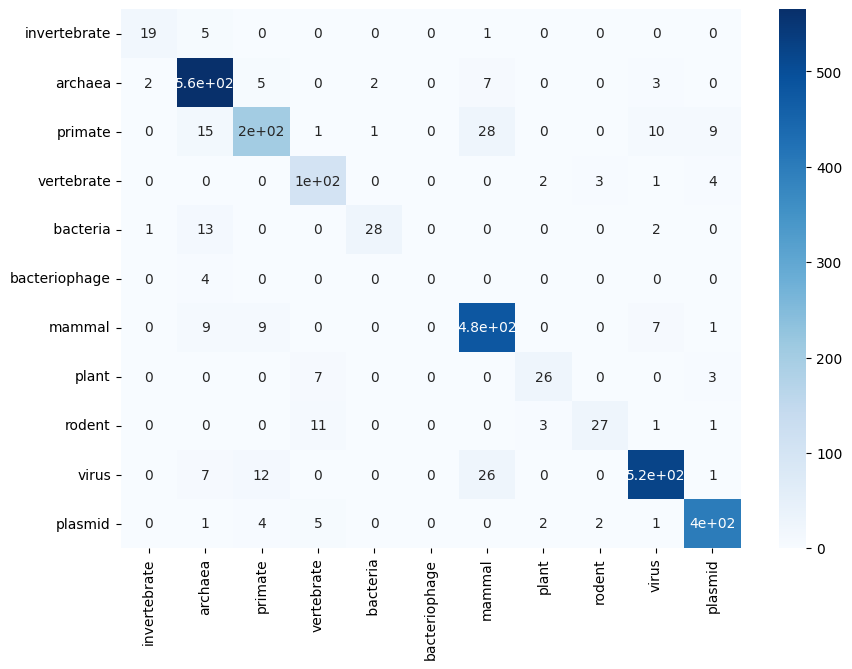

In [47]:
DNA_Types = []

for item in y_test.unique():
    DNA_Types.append(Kingdoms[item])

for item in y_pred:
    DNA_Types.append(Kingdoms[item])

DNA_Types = list(set(DNA_Types))

knn_array = confusion_matrix(y_test, y_pred)
df_knn_confusion = pd.DataFrame(knn_array, 
    index = [i for i in DNA_Types],
    columns = [i for i in DNA_Types]
)

plt.figure(figsize = (10,7))
sns.heatmap(df_knn_confusion, annot=True, cmap='Blues')
plt.show()

### Random Forest Classifier Model

In [48]:
rfc = RandomForestClassifier()

ada_rf = AdaBoostClassifier(estimator=rfc, n_estimators= 180, random_state= 1)

ada_rf.fit(X_train, y_train)

y_pred = ada_rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
print(ada_rf.score(X_test, y_test))

[[ 13   9   0   0   0   0   1   0   0   2   0]
 [  1 560   8   0   2   0   9   0   0   4   0]
 [  0  16 189   0   0   0  22   0   0  39   3]
 [  0   0   0  88   0   0   0   1   2   3  20]
 [  2  11   0   0  28   0   1   0   0   2   0]
 [  0   4   0   0   0   0   0   0   0   0   0]
 [  0  14   8   0   0   0 461   0   0  22   0]
 [  0   0   0   4   0   0   0  23   1   0   8]
 [  0   0   0   5   0   0   1   1  26   2   8]
 [  0   4   2   0   0   0   6   0   0 555   0]
 [  0   1   5   1   0   0   2   0   0   7 399]]
              precision    recall  f1-score   support

           0       0.81      0.52      0.63        25
           1       0.90      0.96      0.93       584
           2       0.89      0.70      0.79       269
           3       0.90      0.77      0.83       114
           4       0.93      0.64      0.76        44
           5       0.00      0.00      0.00         4
           6       0.92      0.91      0.91       505
           7       0.92      0.64      0.75      

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
#Test Evaluation
test_df = pd.DataFrame([y_test.tolist(), y_pred.tolist()])
test_df = test_df.transpose()

test_df = test_df.rename(columns = { 0: "y_test", 1: "y_predict"})
test_df['Check'] = np.where(test_df['y_test'] == test_df['y_predict'], 1, 0)


total_test_case = test_df.Check.count()
correct_test_predict = test_df.value_counts('Check')[1]
incorrect_test_predict = test_df.value_counts('Check')[0]

print("Number of All Test Cases: {}".format(total_test_case))

print("Number of Correct Prediction: {}".format(correct_test_predict))

print("Number of Incorrect Prediction: {}".format(incorrect_test_predict))

Number of All Test Cases: 2606
Number of Correct Prediction: 2356
Number of Incorrect Prediction: 250


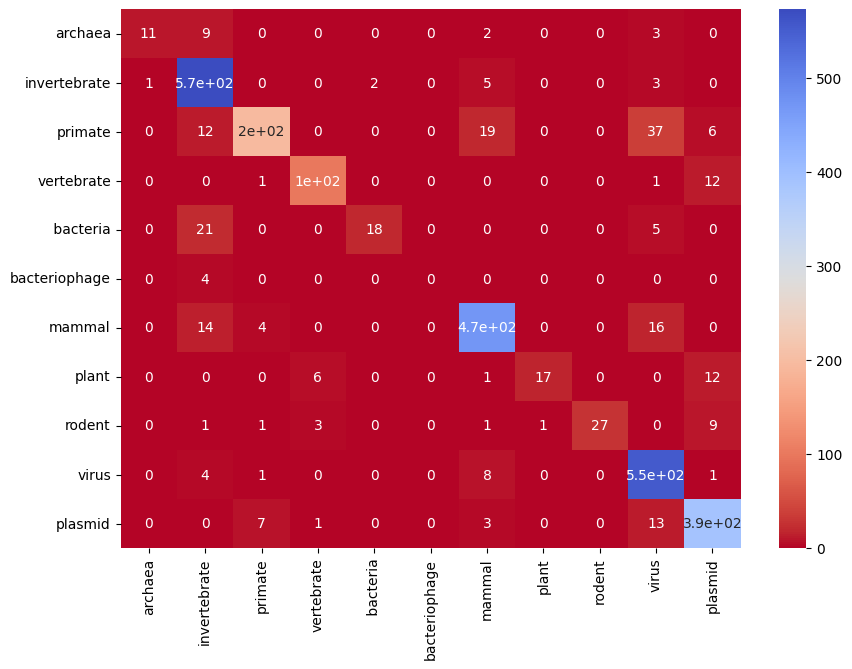

In [ ]:
DNA_Types = []

for item in y_test.unique():
    DNA_Types.append(Kingdoms[item])

for item in y_pred:
    DNA_Types.append(Kingdoms[item])

DNA_Types = list(set(DNA_Types))

rfc_array = confusion_matrix(y_test, y_pred)
df_rfc_confusion = pd.DataFrame(rfc_array, 
    index = [i for i in DNA_Types],
    columns = [i for i in DNA_Types]
)

plt.figure(figsize = (10,7))
sns.heatmap(df_rfc_confusion, annot=True, cmap='coolwarm_r')
plt.show()

### Decision Tree Classifier Model

In [ ]:
dt = DecisionTreeClassifier(random_state= 1)

ada_dt = AdaBoostClassifier(estimator=dt, random_state = 1)

ada_dt.fit(X_train, y_train)

y_pred = ada_dt.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
print(dt.score(X_test, y_test))

[[ 12   7   2   0   1   0   0   0   0   2   1]
 [  3 494  17   2  15   3  31   0   0  15   4]
 [  0  23 158   5   6   1  27   1   1  37  10]
 [  0   0   1  84   0   0   1   4  11   2  11]
 [  0  14   2   0  24   0   2   0   0   1   1]
 [  0   4   0   0   0   0   0   0   0   0   0]
 [  2  33  41   2   0   0 376   1   1  43   6]
 [  0   0   1  10   0   0   1  14   5   0   5]
 [  0   1   1   9   0   0   2   1  21   1   7]
 [  4  15  41   2   3   0  44   1   0 445  12]
 [  0   2  10  13   1   0   7  11   5   9 357]]
              precision    recall  f1-score   support

           0       0.57      0.48      0.52        25
           1       0.83      0.85      0.84       584
           2       0.58      0.59      0.58       269
           3       0.66      0.74      0.70       114
           4       0.48      0.55      0.51        44
           5       0.00      0.00      0.00         4
           6       0.77      0.74      0.76       505
           7       0.42      0.39      0.41      

In [ ]:
#Test Evaluation
test_df = pd.DataFrame([y_test.tolist(), y_pred.tolist()])
test_df = test_df.transpose()

test_df = test_df.rename(columns = { 0: "y_test", 1: "y_predict"})
test_df['Check'] = np.where(test_df['y_test'] == test_df['y_predict'], 1, 0)


total_test_case = test_df.Check.count()
correct_test_predict = test_df.value_counts('Check')[1]
incorrect_test_predict = test_df.value_counts('Check')[0]

print("Number of All Test Cases: {}".format(total_test_case))

print("Number of Correct Prediction: {}".format(correct_test_predict))

print("Number of Incorrect Prediction: {}".format(incorrect_test_predict))

Number of All Test Cases: 2606
Number of Correct Prediction: 1985
Number of Incorrect Prediction: 621


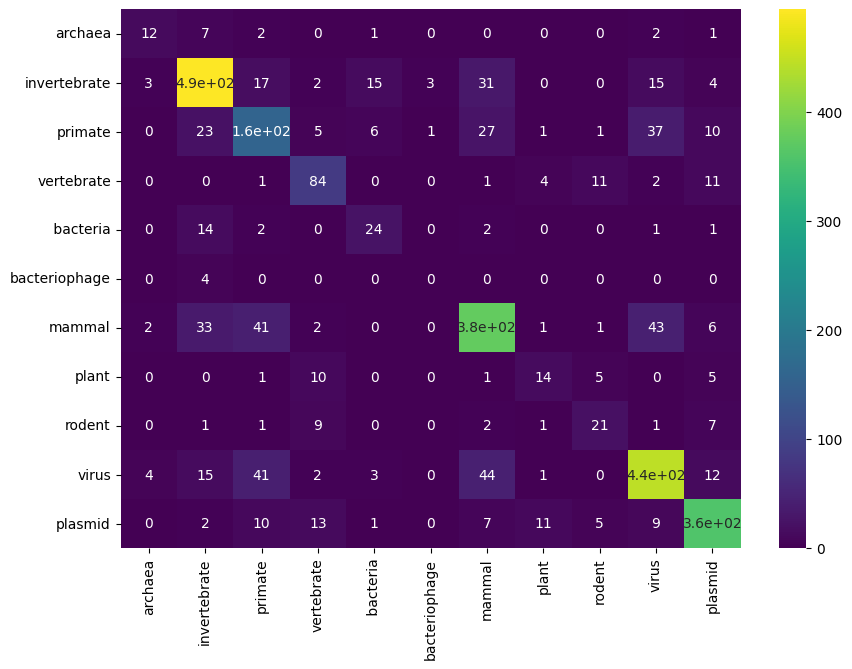

In [ ]:
DNA_Types = []

for item in y_test.unique():
    DNA_Types.append(Kingdoms[item])

for item in y_pred:
    DNA_Types.append(Kingdoms[item])

DNA_Types = list(set(DNA_Types))

dt_array = confusion_matrix(y_test, y_pred)
df_dt_confusion = pd.DataFrame(dt_array, 
    index = [i for i in DNA_Types],
    columns = [i for i in DNA_Types]
)

plt.figure(figsize = (10,7))
sns.heatmap(df_dt_confusion, annot=True, cmap='viridis')
plt.show()

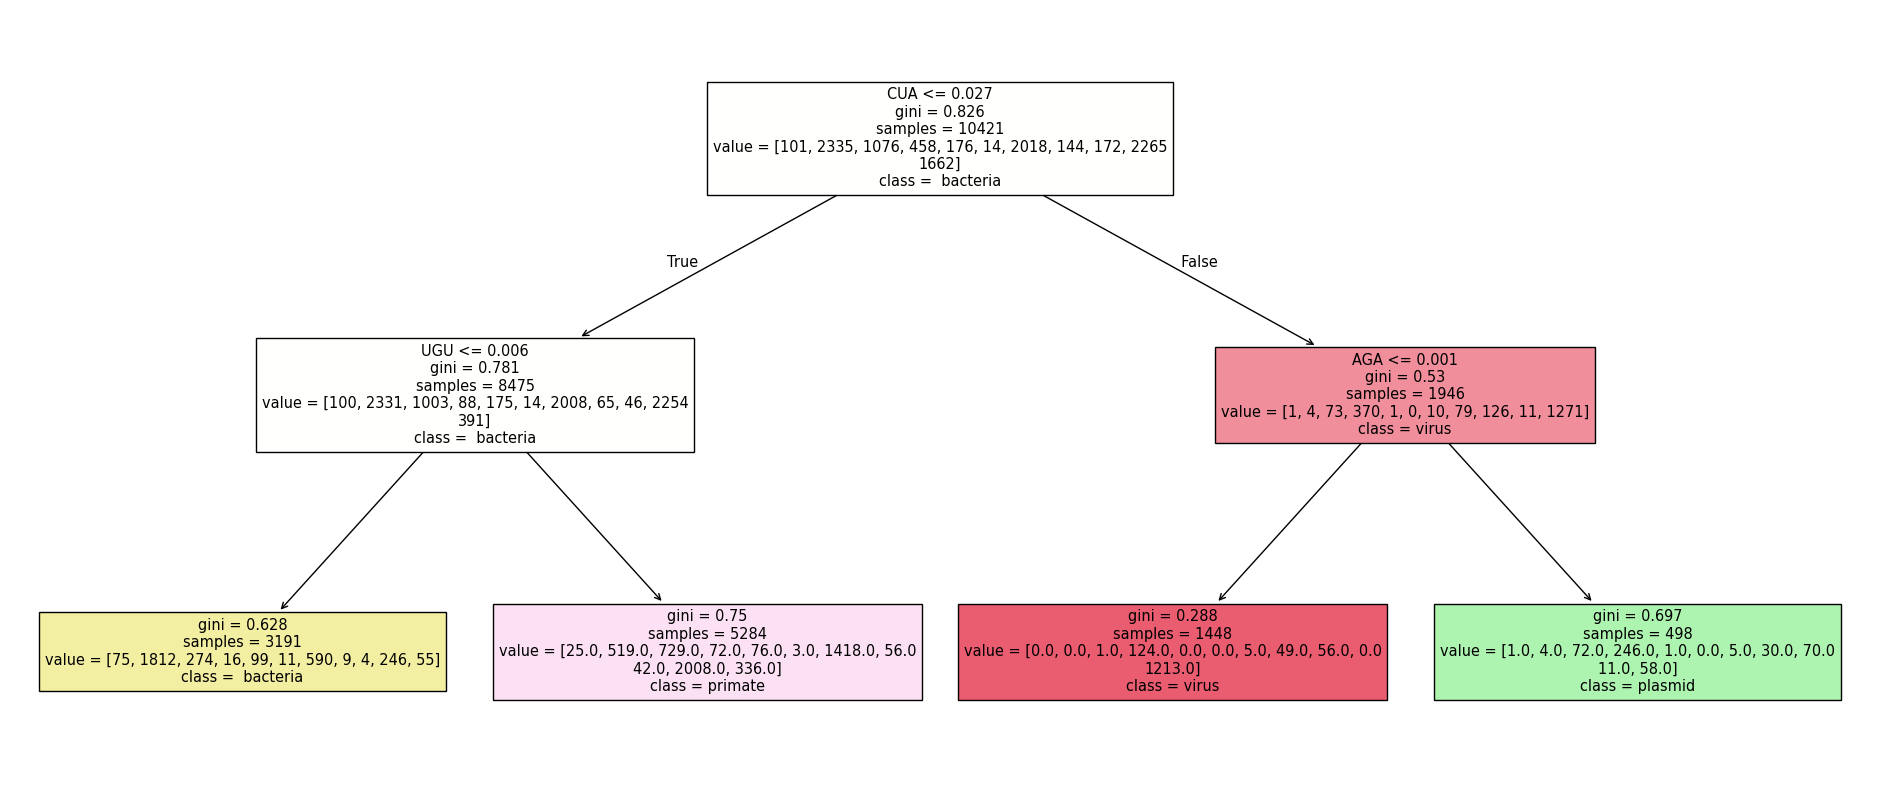

In [ ]:
from sklearn import tree

dt = DecisionTreeClassifier(max_depth = 2, random_state = 1)
dt.fit(X_train, y_train)

fig = plt.figure(figsize=(24,10))
_ = tree.plot_tree(dt, feature_names = X.columns, filled = True, class_names = list(Kingdoms.values()))